# PGF5005 — Hénon–Heiles · **5.3–5.4 (versão com LOGs)**  
Seções de Poincaré com **Euler simplético**, cruzamento por **interpolação linear** e **logging detalhado**.

O caderno imprime:
- intervalo permitido de \(q_2\) para a energia \(E\);
- progresso por **IC**: cruzamentos coletados, tempo por IC e avisos quando a trajetória estoura;
- totais finais de pontos e tempo.

A seção é \(\Sigma:\ q_1=0,\ p_1\ge 0\) e o gráfico é **\(p_2 \times q_2\)**.


## 1) Modelo HH e passo Euler simplético

In [1]:
import math, time, sys, os
import numpy as np
import matplotlib.pyplot as plt

def H(q1,q2,p1,p2):
    return 0.5*(p1*p1 + p2*p2 + q1*q1 + q2*q2) + q1*q1*q2 - (1.0/3.0)*q2*q2*q2

def euler_symplectic_step(q1,q2,p1,p2, dt):
    q1n = q1 + dt*p1
    q2n = q2 + dt*p2
    dU1 = q1n + 2.0*q1n*q2n
    dU2 = q2n + q1n*q1n - q2n*q2n
    p1n = p1 - dt*dU1
    p2n = p2 - dt*dU2
    return q1n,q2n,p1n,p2n


## 2) Utilitários de LOG

In [2]:
def log(msg):
    print(msg)
    sys.stdout.flush()

class Timer:
    def __init__(self):
        self.t0 = time.time()
    def lap(self):
        return time.time() - self.t0


## 3) Seção de Hénon com LOG (interpolação linear no cruzamento)

In [3]:
def henon_section_q1_zero_stream(q1,q2,p1,p2, dt, max_points=800, T_max=6000.0,
                                 blowup=10.0, ic_idx=None, every=200):
    pts_q2, pts_p2 = [], []
    t = 0.0; steps = 0
    q1n,q2n,p1n,p2n = q1,q2,p1,p2
    while t < T_max and len(pts_q2) < max_points:
        q1m,q2m,p1m,p2m = euler_symplectic_step(q1n,q2n,p1n,p2n, dt)
        if q1n*q1m < 0.0:
            s = q1n / (q1n - q1m)  # 0<s<1
            q2_star = q2n + s*(q2m - q2n)
            p1_star = p1n + s*(p1m - p1n)
            p2_star = p2n + s*(p2m - p2n)
            if p1_star >= 0.0:
                pts_q2.append(q2_star); pts_p2.append(p2_star)
                if ic_idx is not None and (len(pts_q2) % every == 0):
                    log(f"[IC {ic_idx}] cruzamentos: {len(pts_q2)} (t={t:.2f})")  # progresso
        q1n,q2n,p1n,p2n = q1m,q2m,p1m,p2m
        t += dt; steps += 1
        if max(abs(q1n),abs(q2n),abs(p1n),abs(p2n)) > blowup:
            log(f"[IC {ic_idx}] ABORTADA por estouro: |state|> {blowup} em t={t:.2f}")
            break
    return np.array(pts_q2), np.array(pts_p2), steps, t


## 4) ICs sobre a seção (p1=0) e intervalo permitido de q2 (com LOG)

In [4]:
def allowed_q2_for_p2(E, p1=0.0, n_samples=4000):
    q2_grid = np.linspace(-0.6, 1.2, n_samples)
    rad = 2*E - q2_grid**2 + (2.0/3.0)*q2_grid**3 - p1**2
    return q2_grid[rad >= 0.0]

def p2_from_energy(E, q2, p1=0.0):
    rad = max(0.0, 2*E - q2*q2 + (2.0/3.0)*q2*q2*q2 - p1*p1)
    return math.sqrt(rad)


## 5) Construção da seção para um \(E\) **com logging de progresso**

In [5]:
def poincare_section_energy_logged(E, dt=5e-4, N_per_ic=600, T_max=6000.0, n_ic=30,
                                   p1_ic=0.0, jitter=1e-6, every=200):
    t_total = Timer()
    q2_allowed = allowed_q2_for_p2(E, p1=p1_ic)
    if len(q2_allowed) == 0:
        log(f"[E={E:.5f}] Nenhum q2 permitido (radicando<0).") 
        return np.array([]), np.array([])

    log(f"[E={E:.5f}] q2 permitido: [{q2_allowed.min():.4f}, {q2_allowed.max():.4f}] "+
        f" (amostras={len(q2_allowed)})")
    idx = np.linspace(0, len(q2_allowed)-1, n_ic).astype(int)
    q2_ics = q2_allowed[idx] + jitter*np.random.randn(n_ic)

    all_q2, all_p2 = [], []
    total_cross = 0
    for i, q2_0 in enumerate(q2_ics, 1):
        p2_0 = p2_from_energy(E, q2_0, p1=p1_ic)
        t_ic = Timer()
        q2_pts, p2_pts, steps, t_last = henon_section_q1_zero_stream(
            0.0, q2_0, p1_ic, p2_0, dt, max_points=N_per_ic, T_max=T_max,
            blowup=10.0, ic_idx=i, every=every)
        all_q2.append(q2_pts); all_p2.append(p2_pts)
        total_cross += len(q2_pts)
        log(f"[E={E:.5f}] IC {i:02d}/{n_ic} → cruzamentos={len(q2_pts)}; passos={steps}; tempo={t_ic.lap():.2f}s")

    log(f"[E={E:.5f}] TOTAL de pontos coletados: {total_cross} em {t_total.lap():.2f}s")
    return np.concatenate(all_q2), np.concatenate(all_p2)


## 6) Driver para E=0.08333 e E=0.125 (com LOG + salvamento opcional)

=== Rodando E=0.08333 ===
[E=0.08333] q2 permitido: [-0.3632, 0.4947]  (amostras=1907)
[IC 1] cruzamentos: 200 (t=1236.88)
[IC 1] cruzamentos: 400 (t=2474.27)
[IC 1] cruzamentos: 600 (t=3712.03)
[IC 1] cruzamentos: 800 (t=4949.88)
[E=0.08333] IC 01/40 → cruzamentos=800; passos=9899768; tempo=7.93s
[IC 2] cruzamentos: 200 (t=1236.29)
[IC 2] cruzamentos: 400 (t=2473.85)
[IC 2] cruzamentos: 600 (t=3711.68)
[IC 2] cruzamentos: 800 (t=4949.41)
[E=0.08333] IC 02/40 → cruzamentos=800; passos=9898817; tempo=7.98s
[IC 3] cruzamentos: 200 (t=1235.93)
[IC 3] cruzamentos: 400 (t=2473.67)
[IC 3] cruzamentos: 600 (t=3710.99)
[IC 3] cruzamentos: 800 (t=4948.16)
[E=0.08333] IC 03/40 → cruzamentos=800; passos=9896313; tempo=8.03s
[IC 4] cruzamentos: 200 (t=1235.75)
[IC 4] cruzamentos: 400 (t=2473.26)
[IC 4] cruzamentos: 600 (t=3710.15)
[IC 4] cruzamentos: 800 (t=4947.31)
[E=0.08333] IC 04/40 → cruzamentos=800; passos=9894611; tempo=8.02s
[IC 5] cruzamentos: 200 (t=1235.63)
[IC 5] cruzamentos: 400 (t=24

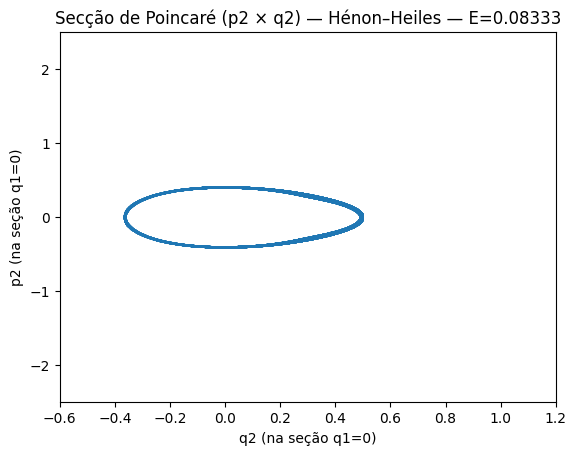


=== Rodando E=0.12500 ===
[E=0.12500] q2 permitido: [-0.4375, 0.6680]  (amostras=2457)
[IC 1] cruzamentos: 200 (t=1143.09)
[IC 1] cruzamentos: 400 (t=2286.17)
[IC 1] cruzamentos: 600 (t=3428.92)
[IC 1] cruzamentos: 800 (t=4571.37)
[E=0.12500] IC 01/40 → cruzamentos=800; passos=9142742; tempo=7.39s
[IC 2] cruzamentos: 200 (t=1143.94)
[IC 2] cruzamentos: 400 (t=2286.59)
[IC 2] cruzamentos: 600 (t=3429.66)
[IC 2] cruzamentos: 800 (t=4572.90)
[E=0.12500] IC 02/40 → cruzamentos=800; passos=9145794; tempo=7.44s
[IC 3] cruzamentos: 200 (t=1143.84)
[IC 3] cruzamentos: 400 (t=2287.16)
[IC 3] cruzamentos: 600 (t=3432.17)
[IC 3] cruzamentos: 800 (t=4575.59)
[E=0.12500] IC 03/40 → cruzamentos=800; passos=9151187; tempo=7.41s
[IC 4] cruzamentos: 200 (t=1144.27)
[IC 4] cruzamentos: 400 (t=2288.57)
[IC 4] cruzamentos: 600 (t=3433.15)
[IC 4] cruzamentos: 800 (t=4577.13)
[E=0.12500] IC 04/40 → cruzamentos=800; passos=9154264; tempo=7.42s
[IC 5] cruzamentos: 200 (t=1144.64)
[IC 5] cruzamentos: 400 (t=2

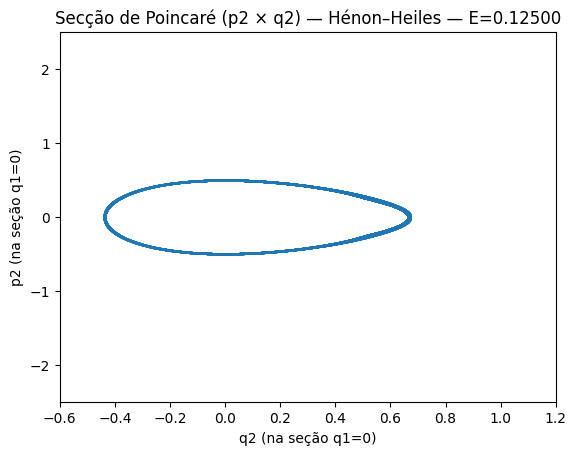


Arquivos salvos em ./figs (se `save` foi usado).


In [7]:
def plot_section(q2_pts, p2_pts, E, save=None, xlim=(-0.6,1.2), ylim=(-2.5,2.5)):
    plt.figure()
    plt.plot(q2_pts, p2_pts, '.', ms=1.0)
    plt.xlabel('q2 (na seção q1=0)')
    plt.ylabel('p2 (na seção q1=0)')
    plt.title(f'Secção de Poincaré (p2 × q2) — Hénon–Heiles — E={E:.5f}')
    if xlim: plt.xlim(*xlim)
    if ylim: plt.ylim(*ylim)
    if save:
        os.makedirs('figs', exist_ok=True)
        plt.savefig(save, dpi=260, bbox_inches='tight')
    plt.show()

# Presets
dt = 5e-4; N_per_ic = 800; n_ic = 40; T_max = 8000.0; p1_ic = 0.05

E1, E2 = 0.08333, 0.12500
log('=== Rodando E=0.08333 ===')
q2_1, p2_1 = poincare_section_energy_logged(E1, dt=dt, N_per_ic=N_per_ic, T_max=T_max,
                                            n_ic=n_ic, p1_ic=p1_ic, every=200)
plot_section(q2_1, p2_1, E1, save='figs/HH_E_008333_logged.png')

log('\n=== Rodando E=0.12500 ===')
q2_2, p2_2 = poincare_section_energy_logged(E2, dt=dt, N_per_ic=N_per_ic, T_max=T_max,
                                            n_ic=n_ic, p1_ic=p1_ic, every=200)
plot_section(q2_2, p2_2, E2, save='figs/HH_E_012500_logged.png')

print('\nArquivos salvos em ./figs (se `save` foi usado).')